In [4]:
from orphics import sehgal, maps
import healpy as hp
from pixell import utils, enmap, curvedsky, enplot, wcsutils
import os
import numpy as np

import matplotlib.pyplot as plt
import lmdb
from cosmikyu import datasets, transforms

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### !!! Refactored / Not Tested

In [7]:
np.save?

In [ ]:
sehgal_dir = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/inputs/microwaveSky"
output_dir = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/131020_hybrid_projection"
def output_path(x):
    return os.path.join(output_dir, x)

SEHGAL10 = sehgal.SehgalSky2010(path=sehgal_dir, data_type='healpix')
TEMP_ALM = sehgal.SehgalSky2010(path=output_dir, data_type='alm')
TEMP_ENMAP = sehgal.SehgalSky2010(path=output_dir, data_type='enmap')

rfs = {"kappa": lambda : SEHGAL10.get_kappa(),
       "ksz": lambda : SEHGAL10.get_ksz(148),
       "tsz": lambda :SEHGAL10.get_tsz(148),
       "rad_pts": lambda :SEHGAL10.get_radio(148),
       "ir_pts": lambda :SEHGAL10.get_cib(148)
      }

rfs_alm = {"kappa": lambda x: TEMP_ALM.get_kappa(filename_only=x),
       "ksz": lambda x: TEMP_ALM.get_ksz(148,filename_only=x),
       "tsz": lambda x:TEMP_ALM.get_tsz(148,filename_only=x),
       "rad_pts": lambda x:TEMP_ALM.get_radio(148,filename_only=x),
       "ir_pts": lambda x:TEMP_ALM.get_cib(148,filename_only=x)
      }

rot_angles1 = [0, 15]# 30, 45, 60, 75]
rot_angles2 = [0, 20, 40]#, 60, 80]
lmax = 10000
shape, wcs = enmap.fullsky_geometry(res=0.5*utils.arcmin)
for compt_idx in ["kappa"]:#, "ksz", "tsz"]:
    print(compt_idx)
    freq_idx = "148_" if compt_idx != "kappa" else ""
    temp_path = output_path("%s%s_alm_%s_%s_000.fits")
    ref_file = temp_path %(freq_idx, compt_idx, "%0.3d"%0, "%0.3d"%0)
    if not os.path.exists(ref_file):
        print("saving", ref_file)
        alm_ref = hp.map2alm(rfs[compt_idx](), lmax=lmax)
        hp.fitsfunc.write_alm(ref_file, alm_ref, overwrite=True)
    else:
        pass

    for i, rot_angle1 in enumerate(rot_angles1):
        for j, rot_angle2 in enumerate(rot_angles2):
            target_file = temp_path %(freq_idx, compt_idx, "%0.3d"%rot_angle1, "%0.3d"%rot_angle2)
            if not os.path.exists(target_file):
                if rot_angle2 != 0: 
                    print("saving ", target_file)
                    if j == 1:
                        ref_file = temp_path %(freq_idx, compt_idx, "%0.3d"%0, "%0.3d"%0)
                        print("loading ", ref_file)
                        alm = np.complex128(hp.read_alm(ref_file))
                        hp.rotate_alm(alm, rot_angle1*utils.degree, rot_angle2*utils.degree, 0, lmax=lmax)
                    else:
                        ref_file = temp_path %(freq_idx, compt_idx, "%0.3d"%rot_angle1, "%0.3d"%rot_angles2[j-1])
                        print("loading ", ref_file)
                        alm = np.complex128(hp.read_alm(ref_file))
                        hp.rotate_alm(alm, 0,  (rot_angles2[j]-rot_angles2[j-1])*utils.degree, 0, lmax=lmax)
                    hp.fitsfunc.write_alm(target_file, alm, overwrite=True)
                else:
                    continue
            else:
                continue
               
    
    
## with flux cut
#flux_cut = 15*1e-3 # flux cut in Jy
flux_cuts = {"rad_pts": (1e-4, 20e-3),
             "ir_pts": (5e-3, 20e-3),
            }
NSIDE = 8192
hparea =  hp.pixelfunc.nside2pixarea(NSIDE)
for compt_idx in ["rad_pts","ir_pts"]:
    print(compt_idx)
    freq_idx = "148_" if compt_idx != "kappa" else ""
    temp_path = output_path("%s%s_alm_%s_%s_000.fits")
    ref_file = temp_path %(freq_idx, compt_idx, "%0.3d"%0, "%0.3d"%0)
    if not os.path.exists(ref_file):
        print("saving", ref_file)
        hpmap = rfs[compt_idx]()
        loflux_cut, hiflux_cut = flux_cuts[compt_idx]
        assert(hiflux_cut >= loflux_cut)
        
        loc = np.where(np.abs(hpmap) >= hiflux_cut/hparea*sehgal.jysr2thermo(148))
        hpmap[loc] = 0
        hpmap_hi = hpmap.copy()
        loc = np.where(np.abs(hpmap_hi) <= loflux_cut/hparea*sehgal.jysr2thermo(148))
        hpmap_lo = hpmap_hi.copy()
        hpmap_hi[loc] = 0 
        hpmap_lo = hpmap-hpmap_hi

        loc = np.where(hpmap != 0)
        ntot = len(loc[0])
        loc = np.where(hpmap_hi != 0)
        nhi = len(loc[0])
        loc = np.where(hpmap_lo != 0)
        nlo = len(loc[0])

        print("ntot", ntot, "nhi", nhi, "nlo", nlo,)
        
        loc = np.where(hpmap_hi != 0)
        ra, dec = hp.pixelfunc.pix2ang(NSIDE, loc[0], lonlat=True)
        print(np.max(ra),np.min(ra), np.max(dec),np.min(dec))
        hiflux_cat = np.zeros((len(loc[0]),3))
        hiflux_cat[:,0] = dec*utils.degree#-np.pi/2
        hiflux_cat[:,1] = ra*utils.degree-np.pi
        hiflux_cat[:,2] = hpmap_hi[loc]*hparea
        np.save(output_path("%s%s_highflux_cat.npy"%(freq_idx, compt_idx)), hiflux_cat)
        del hpmap_hi
        
        #alm_lo = curvedsky.map2alm_healpix(hpmap_lo, lmax=lmax)
        alm_ref = hp.map2alm(hpmap_lo, lmax=lmax)
        hp.fitsfunc.write_alm(ref_file, alm_ref, overwrite=True)
        del hpmap_lo
        
    else:
        pass

    for i, rot_angle1 in enumerate(rot_angles1):
        for j, rot_angle2 in enumerate(rot_angles2):
            target_file = temp_path %(freq_idx, compt_idx, "%0.3d"%rot_angle1, "%0.3d"%rot_angle2)
            if not os.path.exists(target_file):
                if rot_angle2 != 0: 
                    print("saving ", target_file)
                    if j == 1:
                        ref_file = temp_path %(freq_idx, compt_idx, "%0.3d"%0, "%0.3d"%0)
                        print("loading ", ref_file)
                        alm = np.complex128(hp.read_alm(ref_file))
                        hp.rotate_alm(alm, rot_angle1*utils.degree, rot_angle2*utils.degree, 0, lmax=lmax)
                    else:
                        ref_file = temp_path %(freq_idx, compt_idx, "%0.3d"%rot_angle1, "%0.3d"%rot_angles2[j-1])
                        print("loading ", ref_file)
                        alm = np.complex128(hp.read_alm(ref_file))
                        hp.rotate_alm(alm, 0,  (rot_angles2[j]-rot_angles2[j-1])*utils.degree, 0, lmax=lmax)
                    hp.fitsfunc.write_alm(target_file, alm, overwrite=True)
                else:
                    continue
            else:
                continue
               
    
    
    

kappa
rad_pts
saving /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/131020_hybrid_projection/148_rad_pts_alm_000_000_000.fits
NSIDE = 8192
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


ntot 49018754 nhi 1900454 nlo 47118300
359.9945068359375 0.0 89.88578658247164 -89.88578658247167
saving  /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/131020_hybrid_projection/148_rad_pts_alm_000_020_000.fits
loading  /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/131020_hybrid_projection/148_rad_pts_alm_000_000_000.fits


In [14]:
shape, wcs = enmap.fullsky_geometry(res= 4*utils.arcmin)
template = enmap.zeros(shape, wcs)

0 0


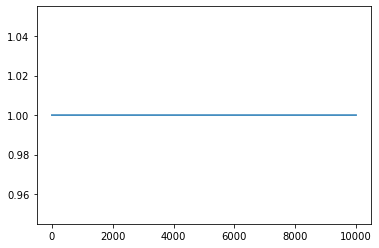

0 20


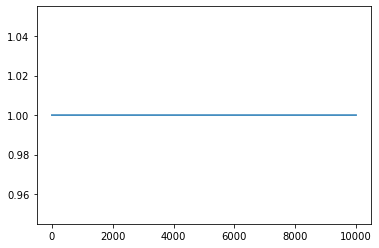

0 40


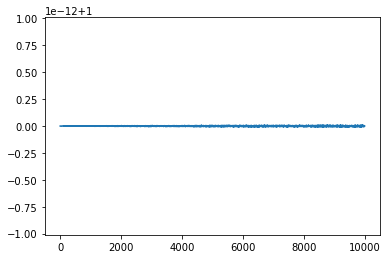

15 20


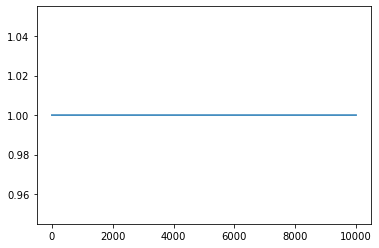

15 40


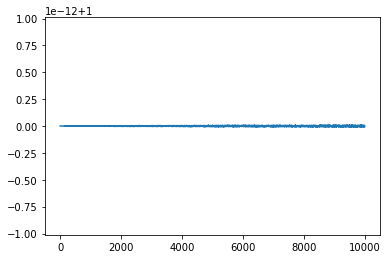

In [6]:
input_dir1 = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/rotated_lmax10000_20mjycuts/"
input_dir2 = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/131020_hybrid_projection"
for i, rot_angle1 in enumerate(rot_angles1):
    for j, rot_angle2 in enumerate(rot_angles2):
        if rot_angle2 == 0 and rot_angle1 != 0:
            continue
        file1_path = os.path.join(input_dir1, "kappa_alm_%s_%s_000.fits" %("%0.3d"%rot_angle1, "%0.3d"%rot_angle2))
        file2_path = os.path.join(input_dir2, "kappa_alm_%s_%s_000.fits" %("%0.3d"%rot_angle1, "%0.3d"%rot_angle2))
        alm1 = np.complex128(hp.read_alm(file1_path))
        alm2 = np.complex128(hp.read_alm(file2_path))
        #enplot.pshow(curvedsky.alm2map(alm1, template))
        #enplot.pshow(curvedsky.alm2map(alm2, template))
        
        cl1 = hp.alm2cl(alm1)
        cl2 = hp.alm2cl(alm2)
        clx = hp.alm2cl(alm1, alm2)
        
        rho = clx/np.sqrt(cl1*cl2)
        
        plt.plot(rho)
        print(rot_angle1, rot_angle2)
        plt.show()